In [11]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from collections import OrderedDict
from pathlib import Path

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import pyLDAvis
from pyLDAvis.sklearn import prepare

from wordcloud import WordCloud
from termcolor import colored

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
import joblib

sns.set_style('white')
plt.rcParams['figure.figsize'] = (16.0, 12)
pyLDAvis.enable_notebook()

# change to your data path if necessary
DATA_DIR = Path('data')
data_path = DATA_DIR / 'bbc'
results_path = Path('results')
model_path = Path('results', 'bbc')
if not model_path.exists():
    model_path.mkdir(exist_ok=True, parents=True)

In [12]:
# Load BBC data
files = sorted(list(data_path.glob('**/*.txt')))
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

In [13]:
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   topic    0 non-null      object
 1   heading  0 non-null      object
 2   article  0 non-null      object
dtypes: object(3)
memory usage: 0.0+ bytes


In [14]:
docs.sample(5)

ValueError: a must be greater than 0 unless no samples are taken

In [66]:
# Create Train & Test Sets
train_docs, test_docs = train_test_split(docs, stratify=docs.topic, test_size=125, random_state=42)
train_docs.shape, test_docs.shape

((2100, 3), (125, 3))

In [67]:
pd.Series(test_docs.topic).value_counts()

Sport            29
Business         29
Politics         23
Tech             22
Entertainment    22
Name: topic, dtype: int64

In [68]:
# experiments with different settings results yields the following hyperparameters (see issue 50)
vectorizer = TfidfVectorizer(max_df=.11, min_df=.026, stop_words='english')

train_dtm = vectorizer.fit_transform(train_docs.article)
words = vectorizer.get_feature_names()
train_dtm

<2100x1097 sparse matrix of type '<class 'numpy.float64'>'
	with 113356 stored elements in Compressed Sparse Row format>

In [69]:
test_dtm = vectorizer.transform(test_docs.article)
test_dtm

<125x1097 sparse matrix of type '<class 'numpy.float64'>'
	with 6779 stored elements in Compressed Sparse Row format>

In [70]:
# LDA with sklearn
n_components = 5
topic_labels = [f'Topic {i}' for i in range(1, n_components+1)]
lda_base = LatentDirichletAllocation(n_components=n_components, n_jobs=-1, learning_method='batch',
                                     max_iter=10)
lda_base.fit(train_dtm)

LatentDirichletAllocation(n_components=5, n_jobs=-1)

In [71]:
# Persist model
joblib.dump(lda_base, model_path / 'lda_10_iter.pkl')

lda_base = joblib.load(model_path / 'lda_10_iter.pkl')
lda_base

LatentDirichletAllocation(n_components=5, n_jobs=-1)

In [72]:
# Explore topics & word distributions

# pseudo counts
topics_count = lda_base.components_
print(topics_count.shape)
topics_count[:5]

(5, 1097)


array([[0.20030413, 0.20029708, 0.20030335, ..., 0.20028208, 0.20032448,
        0.20028674],
       [5.35332133, 6.29031358, 7.36040388, ..., 1.86537524, 8.52840016,
        6.82229948],
       [2.73936811, 4.0877988 , 4.3657774 , ..., 0.2021477 , 4.50259848,
        0.20443257],
       [4.5414362 , 3.41830823, 2.88773855, ..., 5.81784759, 0.81916587,
        4.69819177],
       [1.70323733, 3.07838597, 4.68854956, ..., 2.27034276, 1.85307411,
        4.27488423]])

In [73]:
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T, index=words, columns=topic_labels)
topics.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
100,0.000911,0.001243,0.001420,0.001182,0.000507
11,0.000911,0.001460,0.002120,0.000890,0.000917
12,0.000911,0.001709,0.002264,0.000752,0.001397
13,0.000911,0.001195,0.000845,0.000334,0.001395
14,0.000911,0.000950,0.001323,0.000720,0.000930


In [74]:
# all words have positive probability for all topics
topics[topics.gt(0).all(1)].shape[0] == topics.shape[0]

True

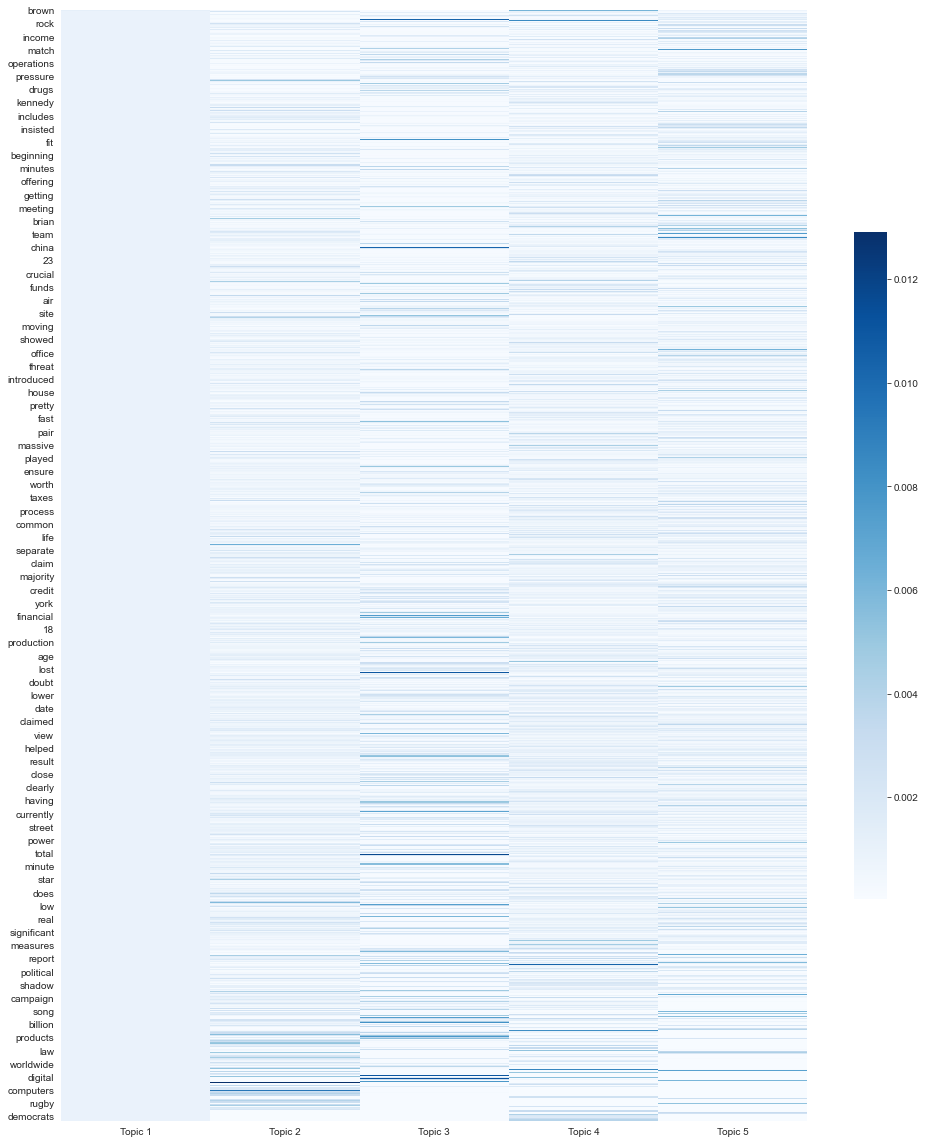

In [75]:
fig, ax = plt.subplots(figsize=(14, 16))
sns.heatmap(topics.sort_values(topic_labels, ascending=False), cmap='Blues', ax=ax, cbar_kws={'shrink': .6})
fig.tight_layout()

In [76]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,brown,film,sales,labour,club
1,book,music,shares,election,match
2,reduce,tv,oil,blair,team
3,economist,technology,bank,party,cup
4,tsunami,mobile,growth,brown,season
5,spending,awards,china,tax,injury
6,improved,users,analysts,law,final
7,fly,digital,prices,prime,ireland
8,slow,software,stock,eu,chelsea
9,growth,award,euros,howard,coach


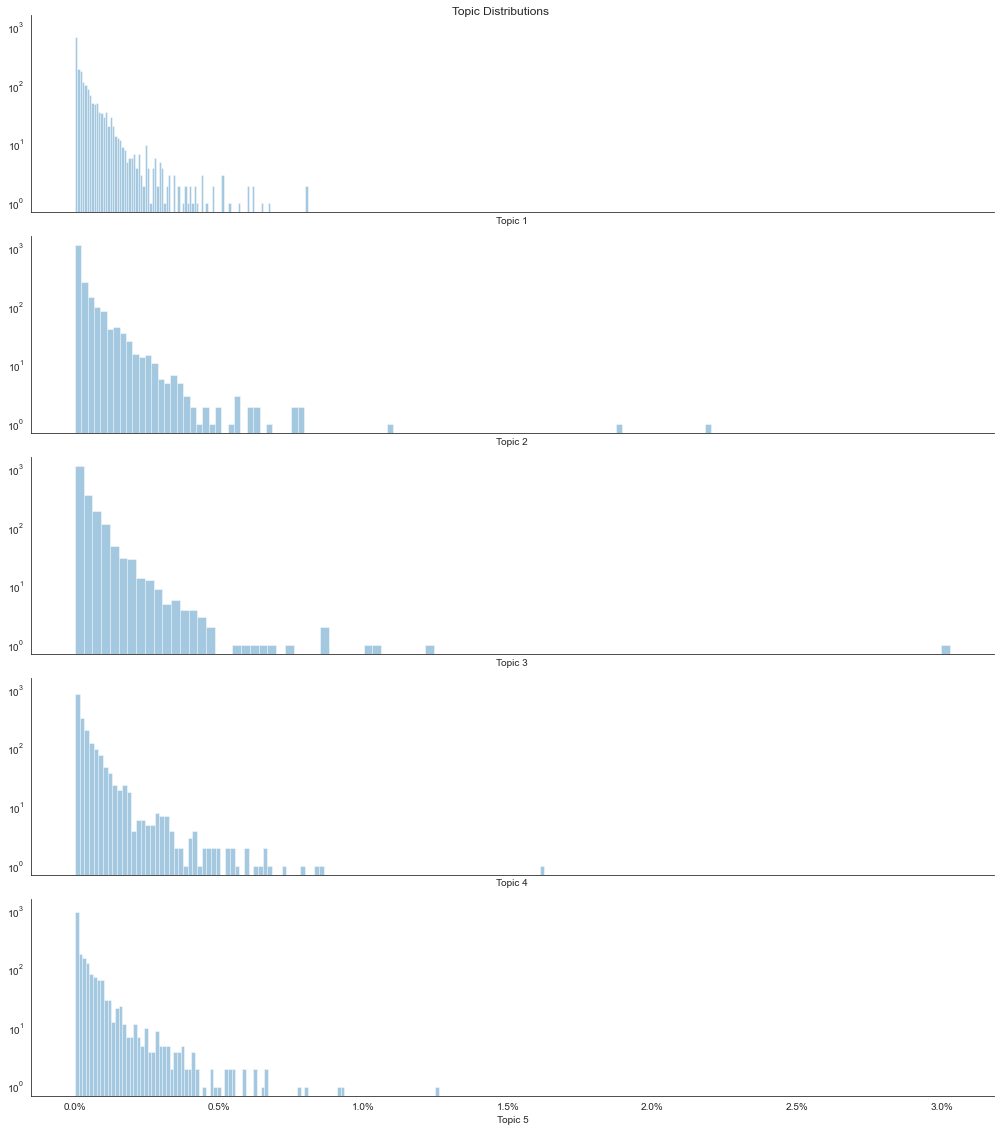

In [130]:
fig, axes = plt.subplots(nrows=5, sharey=True, sharex=True, figsize=(14, 16))
for i, (topic, prob) in enumerate(topics.items()):
    sns.distplot(prob, ax=axes[i], bins=100, kde=False, norm_hist=False)
    axes[i].set_yscale('log')
    axes[i].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
fig.suptitle('Topic Distributions')
sns.despine()
fig.tight_layout()

In [80]:
# Evaluate Fit on Train Set
train_preds = lda_base.transform(train_dtm)
train_preds.shape

(2100, 5)

In [81]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)
train_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
Sport,0.029251,0.029792,0.029637,0.029802,0.881518
Tech,0.029873,0.877906,0.030679,0.031246,0.030296
Politics,0.020743,0.021150,0.020924,0.916055,0.021127
Sport,0.040570,0.041096,0.040879,0.041246,0.836209
Tech,0.029238,0.878854,0.031478,0.029819,0.030611


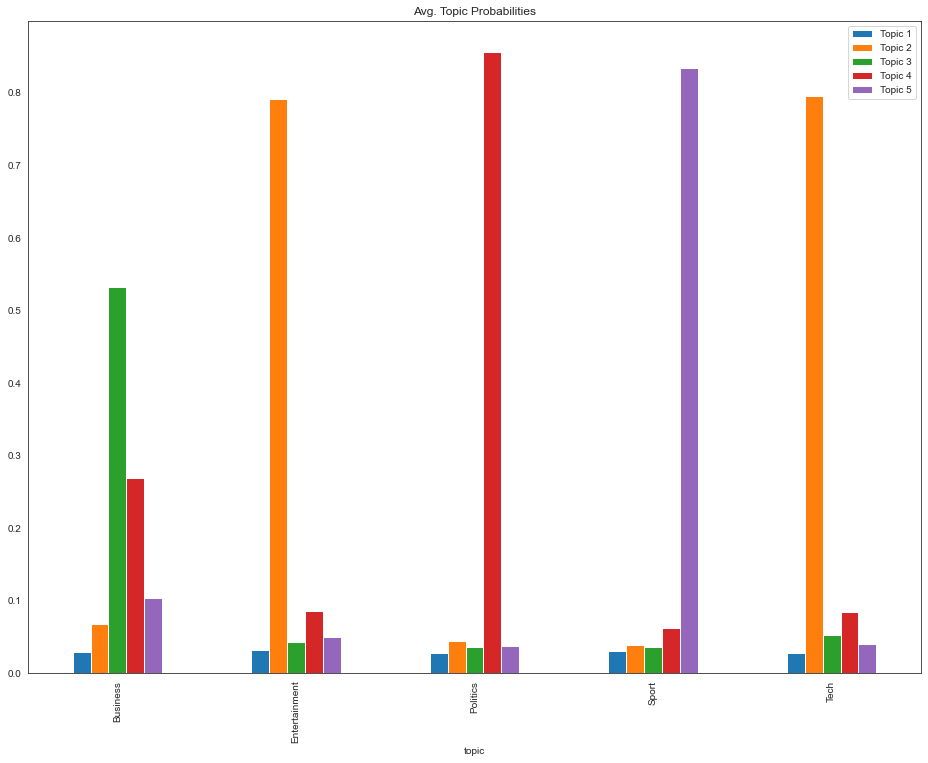

In [82]:
train_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities');

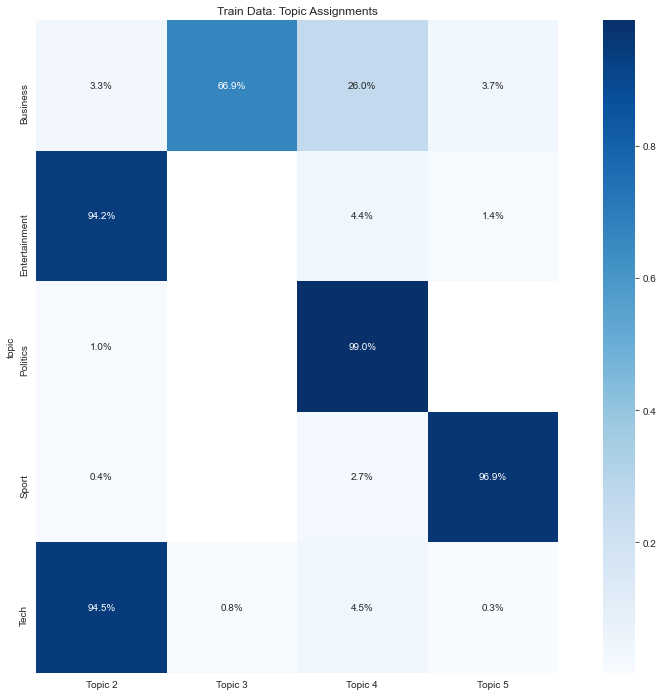

In [83]:
df = train_eval.groupby(level='topic').idxmax(axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Train Data: Topic Assignments');

In [22]:
# Evaluate Fit on Test Set
test_preds = lda_base.transform(test_dtm)
test_eval = pd.DataFrame(test_preds, columns=topic_labels, index=test_docs.topic)
test_eval.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
Politics,0.024752,0.897374,0.024802,0.025408,0.027664
Sport,0.035256,0.036481,0.205723,0.037175,0.685364
Business,0.031089,0.032511,0.031122,0.855315,0.049963
Business,0.030629,0.031204,0.030629,0.876298,0.031240
Tech,0.029562,0.030228,0.029563,0.880347,0.030300


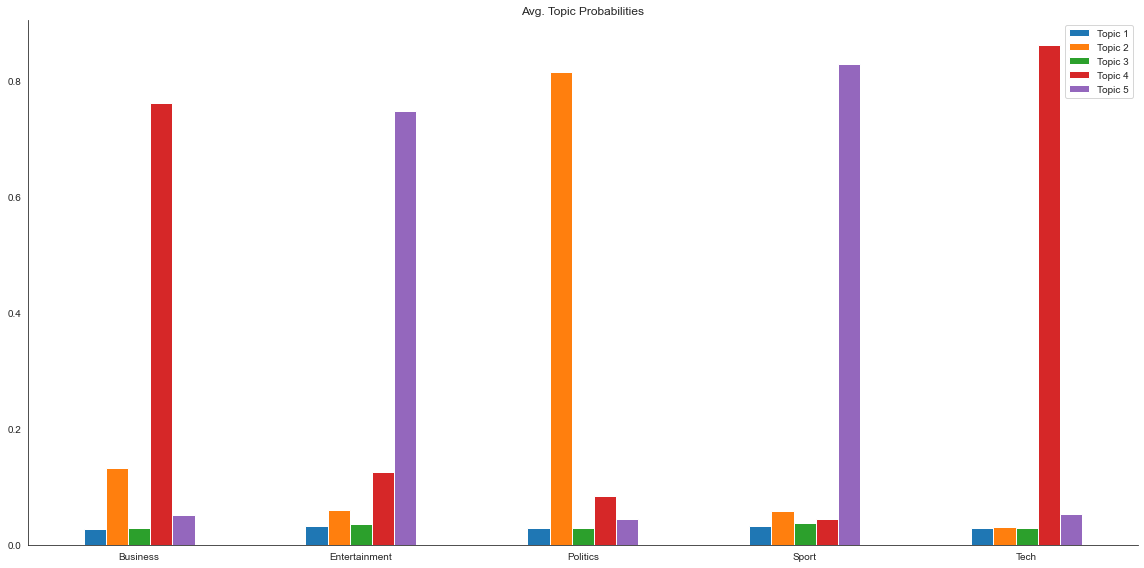

In [23]:
test_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities', figsize=(16, 8), rot=0)
plt.xlabel('')
sns.despine()
plt.tight_layout()

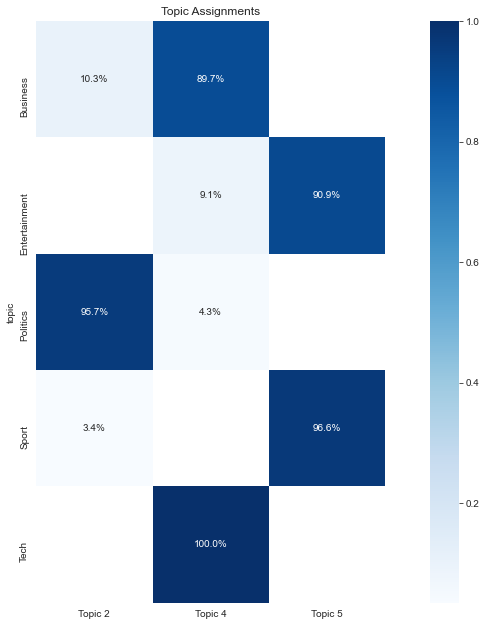

In [42]:
df = test_eval.groupby(level='topic').idxmax(axis=1).reset_index(-1, drop=True)
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True).unstack(-1),
            annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Topic Assignments');

In [85]:
# Retrain until perplexity no longer decreases
lda_opt = LatentDirichletAllocation(n_components=5, n_jobs=-1, max_iter=500, learning_method='batch',
                                    evaluate_every=5, verbose=1, random_state=42)
lda_opt.fit(train_dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500, perplexity: 1942.6115
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 1856.1134
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500, perplexity: 1850.3446
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 1848.8696
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500, perplexity: 1848.5053
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter:

LatentDirichletAllocation(evaluate_every=5, max_iter=500, n_components=5,
                          n_jobs=-1, random_state=42, verbose=1)

In [86]:
joblib.dump(lda_opt, model_path / 'lda_opt.pkl')

['results\\bbc\\lda_opt.pkl']

In [87]:
lda_opt = joblib.load(model_path / 'lda_opt.pkl')

train_opt_eval = pd.DataFrame(data=lda_opt.transform(train_dtm), columns=topic_labels, index=train_docs.topic)
test_opt_eval = pd.DataFrame(data=lda_opt.transform(test_dtm), columns=topic_labels, index=test_docs.topic)

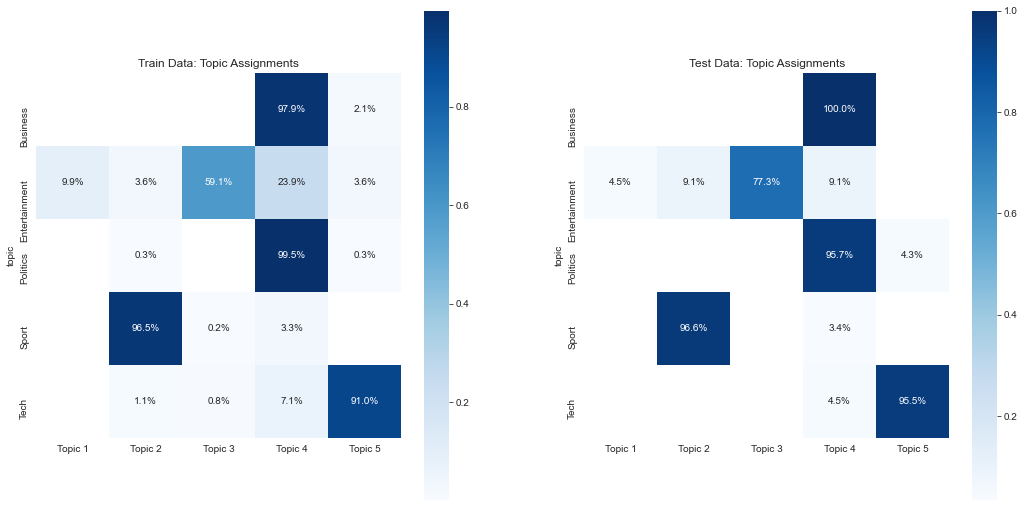

In [88]:
# Compare Train & Test Topic Assignments
fig, axes = plt.subplots(ncols=2, figsize=(18, 9))
source = ['Train', 'Test']
for i, df in enumerate([train_opt_eval, test_opt_eval]):
    df = df.groupby(level='topic').idxmax(axis=1).reset_index(-1, drop=True)
    sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
                .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True, ax=axes[i])
    axes[i].set_title('{} Data: Topic Assignments'.format(source[i]))

In [134]:
# Explore misclassified articles
test_assignments = test_docs.assign(predicted=test_opt_eval.idxmax(axis=1).values)
test_assignments.sample(10)

,topic,heading,article,predicted
1358,Sport,Radcliffe eyes hard line on drugs,Paula Radcliffe has called for all athletes f...,Topic 2
920,Politics,UK 'needs true immigration data',A former Home Office minister has called for ...,Topic 4
688,Entertainment,Housewives lift Channel 4 ratings,The debut of US television hit Desperate Hous...,Topic 3
1195,Politics,Howard denies split over ID cards,Michael Howard has denied his shadow cabinet ...,Topic 4
762,Entertainment,Scissor Sisters triumph at Brits,US band Scissor Sisters led the winners at th...,Topic 2
191,Business,Yukos bankruptcy 'not US matter',Russian authorities do not have to abide by a...,Topic 4
552,Entertainment,Stars pay tribute to actor Davis,"Hollywood stars including Spike Lee, Burt Rey...",Topic 3
1339,Sport,Holmes feted with further honour,Double Olympic champion Kelly Holmes has been...,Topic 2
1299,Politics,Tory candidate quits over remark,A Conservative election challenger is quittin...,Topic 4
1830,Tech,Microsoft releases bumper patches,Microsoft has warned PC users to update their...,Topic 5


In [113]:
test_assignments[(test_assignments.topic == 'Tech') & (test_assignments.predicted == 'Topic 5')].heading

2151         Britons fed up with net service
2212      Mobile multimedia slow to catch on
2137         Junk e-mails on relentless rise
1832       Apple laptop is 'greatest gadget'
2001        Slimmer PlayStation triple sales
1934         Sony wares win innovation award
2087                 Broadband soars in 2004
2074        Video phone help for deaf people
2085        Broadband steams ahead in the US
2141         Ask Jeeves joins web log market
1830       Microsoft releases bumper patches
1864        T-Mobile bets on 'pocket office'
2031     Mobile picture power in your pocket
2211          Camera phones are 'must-haves'
1907       Nintendo handheld given Euro date
2206      Mobile music challenges 'iPod age'
2027       British Library gets wireless net
2046    Satellite mapping aids Darfur relief
1896       'Evil twin' fear for wireless net
2182        Gizmondo gadget hits the shelves
2171       Game makers get Xbox 2 sneak peek
Name: heading, dtype: object

In [120]:
misclassified = test_assignments[(test_assignments.topic == 'Entertainment') & (
    test_assignments.predicted == 'Topic 4')]
misclassified.heading

521    Neeson in bid to revive theatre
677    Campaigners attack MTV 'sleaze'
Name: heading, dtype: object

In [121]:
misclassified.article.tolist()

[' Hollywood film star Liam Neeson has held a dinner party in New York to promote Belfast\'s Lyric Theatre.  The Ballymena-born actor said that the theatre on Ridgeway Street was in a "very dilapidated condition". Lyric chairman David Johnston has said that rebuilding the theatre, at a cost of Â£8m is the only answer. Mr Neeson said that the idea was to get a bunch of "healthy, wealthy Irish Americans" in one room and ask them to help with fundraising.  The Oscar-nominated actor, whose films include Schindler\'s List, Michael Collins and Star Wars: The Phantom Menace, said: "The Lyric is too important to the cultural and social life of Northern Ireland for this building to crumble and fall apart. "It gave me a start professionally. Mary O\'Malley, the founder of the theatre, gave me my future. "In those days, in the mid-70s, when I was there, we were doing a play every four weeks. "Belfast was not a pretty town to be living in. "There was serious trouble, as you know, but this theatre 

In [122]:
# Refit using all data
vectorizer = CountVectorizer(max_df=.5, min_df=5, stop_words='english', max_features=2000)
dtm = vectorizer.fit_transform(docs.article)
lda_all = LatentDirichletAllocation(n_components=5, max_iter=500, learning_method='batch', evaluate_every=10,
                                    random_state=42, verbose=1)
lda_all.fit(dtm)

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 1019.9467
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 1006.8139
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter: 500
iteration: 30 of max_iter: 500, perplexity: 1003.1615
iteration:

LatentDirichletAllocation(evaluate_every=10, max_iter=500, n_components=5,
                          random_state=42, verbose=1)

In [124]:
joblib.dump(lda_all, model_path /'lda_all.pkl')
lda_all = joblib.load(model_path / 'lda_all.pkl')

In [125]:
# pyLDAvis exhibits the global relationships among topics while available for semantic evaluation between each topic and closely related terms and between reversely the related topics with each term
# λ=0.6 in pyLDAvis formula works well for the most founded by user studies

# thus, what we can get from PyLDAVis?
# 1) meaning of each topic
# 2) relationship among each topic
# 3) how prevalent among each topic
prepare(lda_all, dtm, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.073450  0.078507       1        1  25.501837
3      0.095719 -0.098360       2        1  21.840844
0      0.141084  0.011426       3        1  20.954199
4     -0.142908  0.141046       4        1  18.692064
1     -0.167345 -0.132619       5        1  13.011057, topic_info=         Term         Freq        Total Category  logprob  loglift
1200       mr  2987.000000  2987.000000  Default  30.0000  30.0000
724      film   838.000000   838.000000  Default  29.0000  29.0000
230      best   960.000000   960.000000  Default  28.0000  28.0000
1022   labour   770.000000   770.000000  Default  27.0000  27.0000
780      game   855.000000   855.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1081   london   145.604869   454.658340   Topic5  -5.5414   0.9007
1816     time   158.747400  1303.506427   Topic5  -5.4550  -0.0661
1607   series   135.441328   252.071835   Topic5  -5.6138   1.4182
1977    world   147.425268  1173.233921   Topic5  -5.5290  -0.0348
1165  million   135.595694   574.095651   Topic5  -5.6126   0.5963

[353 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.270257      000
0         2  0.219976      000
0         3  0.382130      000
0         4  0.007542      000
0         5  0.121930      000
...     ...       ...      ...
1992      4  0.191599    years
1992      5  0.233952    years
1997      3  0.990918  yugansk
1998      3  0.996584    yukos
1999      4  0.987970  zealand

[672 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 5, 2])

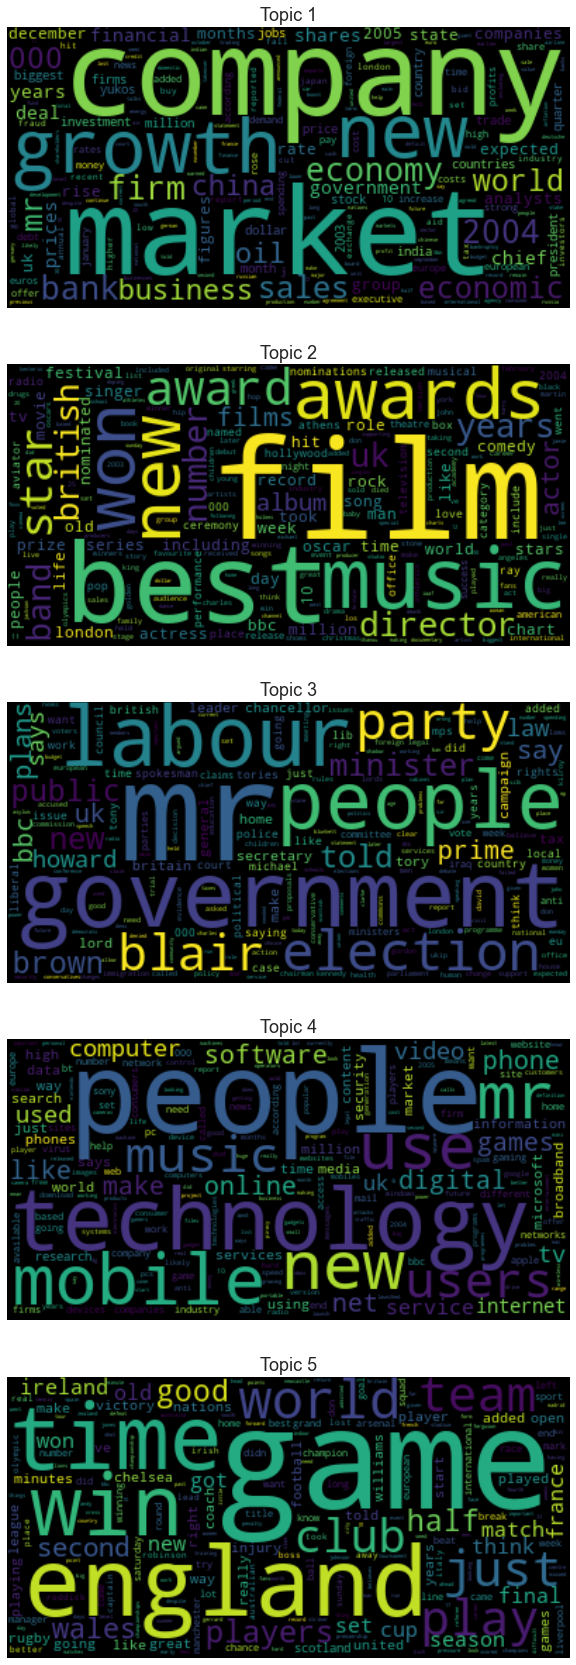

In [126]:
# Topics as WordClouds
topics_prob = lda_all.components_ / lda_all.components_.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T, index=vectorizer.get_feature_names(), columns=topic_labels)
w = WordCloud()
fig, axes = plt.subplots(nrows=5, figsize=(16, 30))
axes = axes.flatten()
for t, (topic, freq) in enumerate(topics.items()):
    w.generate_from_frequencies(freq.to_dict())
    axes[t].imshow(w, interpolation='bilinear')
    axes[t].set_title(topic, fontsize=18)
    axes[t].axis('off')

In [127]:
# Visualize topic-word assocations per document
dtm_ = pd.DataFrame(data=lda_all.transform(dtm), columns=topic_labels, index=docs.topic)
dtm_.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
topic,,,,,
Business,0.757415,0.043291,0.001399,0.196532,0.001363
Business,0.936017,0.001356,0.059912,0.001354,0.001361
Business,0.976877,0.017347,0.001937,0.001917,0.001922
Business,0.994521,0.001373,0.001363,0.001368,0.001375
Business,0.989023,0.002714,0.002762,0.002725,0.002775


In [128]:
color_dict = OrderedDict()
color_dict['Topic 1'] = {'color': 'white', 'on_color': 'on_blue'}
color_dict['Topic 2'] = {'color': 'white', 'on_color': 'on_green'}
color_dict['Topic 3'] = {'color': 'white', 'on_color': 'on_red'}
color_dict['Topic 4'] = {'color': 'white', 'on_color': 'on_magenta'}
color_dict['Topic 5'] = {'color': 'blue', 'on_color': 'on_yellow'}
dtm_['article'] = docs.article.values
dtm_['heading'] = docs.heading.values
sample = dtm_[dtm_[topic_labels].gt(.05).all(1)]
sample

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,article,heading
topic,,,,,,,
Business,0.630684,0.114709,0.128678,0.065489,0.060440,One of Japan's best-known businessmen was arr...,Japanese mogul arrested for fraud
Entertainment,0.064855,0.319108,0.084398,0.225091,0.306548,Broadcaster Chris Evans has begun selling tho...,Chris Evans back on the market
Entertainment,0.055545,0.168249,0.363690,0.284121,0.128394,Angolan families who are attempting to track ...,TV show unites Angolan families
Entertainment,0.051780,0.742649,0.069040,0.065869,0.070662,"Scottish rock band Franz Ferdinand, who shot ...",Franz Ferdinand's art school lesson
Entertainment,0.229219,0.199995,0.417789,0.070954,0.082044,Proposals to open a museum dedicated to Jimi ...,Row threatens Hendrix museum plan
Entertainment,0.100635,0.634550,0.154238,0.055561,0.055016,"Stan Lee, the man responsible for a string of...",The comic book genius of Stan Lee
Entertainment,0.144835,0.280651,0.232055,0.230626,0.111833,Women in the UK film industry earn less than ...,Women in film 'are earning less'
Tech,0.291468,0.073499,0.108780,0.465605,0.060647,Car-maker Honda's humanoid robot Asimo has ju...,Humanoid robot learns how to run


In [129]:
colored_text = []
for word in sample.iloc[0, 5].split():
    try:
        topic = topics.loc[word.strip().lower()].idxmax()
        colored_text.append(colored(word, **color_dict[topic]))
    except:
        colored_text.append(word)

print(' '.join([colored(k, **v) for k, v in color_dict.items()]))
print('\n',sample.iloc[0, 6], '\n')
text = ' '.join(colored_text)
print(text)

Topic 1 Topic 2 Topic 3 Topic 4 Topic 5

 Japanese mogul arrested for fraud 

One of Japan's best-known businessmen was arrested on Thursday on charges of falsifying shareholder information and selling shares based on the false data. Yoshiaki Tsutsumi was once ranked as the world's richest man and ran a business spanning hotels, railways, construction and a baseball team. His is the latest in a series of arrests of top executives in Japan over business scandals. He was taken away in a van outside one of his Prince hotels in Tokyo. There was a time when Mr Tsutsumi seemed untouchable. Inheriting a large property business from his father in the 1960s, he became one of Japan's most powerful industrialists, with close connections to many of the country's leading politicians. He used his wealth and influence to bring the Winter Olympic Games to Nagano in 1998. But last year, he was forced to resign from all the posts he held in his business empire, after being accused of falsifying the shar